In [1]:
%matplotlib inline

import numpy
import scipy.io.wavfile
import scipy.signal as signal
import matplotlib.pyplot as plt
from matplotlib import cm
import math

## The spectrogram converter class

In [173]:
class SpectrogramConverter:
    
    def __init__(self, frame_size, frame_stride, fft_size):
        self.frame_size = frame_size
        self.frame_stride = frame_stride
        self.fft_size = fft_size
   
    def butter_bandpass_filter(self, lowcut, highcut, order=1):
        nyquist_frequency = 0.5 * self.sample_rate
        low_frequency = lowcut / nyquist_frequency
        high_frequency = highcut / nyquist_frequency
        b, a = scipy.signal.butter(order, [low_frequency, high_frequency], btype='band')
        filtered_signal = scipy.signal.lfilter(b, a, self.signal)
        return filtered_signal
    
    def mel_to_hertz(self, mels):
        return 700*(10**(mels/2595.0)-1)
    
    def hertz_to_mel(self, frequency):
        return 2595 * numpy.log10((1 + frequency)/700.)
    
    def load_wav(self, wavfile_path):
        self.sample_rate, self.signal = scipy.io.wavfile.read(wavfile_path)
        
    def pre_emphasis(self, emphasis=0.97):
        self.signal = numpy.append(self.signal[0], self.signal[1:] - emphasis * self.signal[:-1])
    
    def windowing(self):
        frame_length, frame_step = int(round(self.frame_size * self.sample_rate)), int(round(self.frame_stride * self.sample_rate))
        signal_length = len(self.signal)
        frame_amount = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))
        
        pad_signal_length = frame_amount * frame_step + frame_length
        zero_padding = numpy.zeros((pad_signal_length - signal_length))
        padded_signal = numpy.append(self.signal, zero_padding)
        
        indices = numpy.tile(numpy.arange(0, frame_length), (frame_amount, 1)) + numpy.tile(numpy.arange(0, frame_amount * frame_step, frame_step), (frame_length, 1)).T
        signal_frames = padded_signal[indices.astype(numpy.int32, copy=False)]
        
        hamming_window = 0.54 - 0.46 * numpy.cos(2*numpy.pi * numpy.arange(frame_length) / (frame_length - 1))
        self.framed_signal = signal_frames * hamming_window
    
    def fourier_transform(self):
        fft_magnitude = numpy.abs(numpy.fft.rfft(self.framed_signal, self.fft_size)) # Calculate FFT magnitude
        normalized = fft_magnitude / fft_magnitude.max() # Normalize to max 1
        logarithmized = numpy.log10(normalized) # Take logarithm of the FFT
        logarithmized[logarithmized < -2.5] = -2.5 # Denoise the spectrogram
        self.spectrogram = logarithmized
        return self.spectrogram
    
    def power_spectrum(self):
        self.spectrogram = ((1.0 / self.fft_size) * (self.spectrogram ** 2))
    
    def filter_banks(self, filter_amount):
        minimum_frequency = 0
        maximum_frequency = self.hertz_to_mel(self.sample_rate / 2)
        mels = numpy.linspace(minimum_frequency, maximum_frequency, filter_amount + 2)
        bins = numpy.floor((self.fft_size + 1) * self.mel_to_hertz(mels) / self.sample_rate)
        
        filter_banks = numpy.zeros([filter_amount, (self.fft_size // 2) + 1])
        for m in range(0, filter_amount):
            left_equation = int(bins[m])
            center = int(bins[m+1])
            right_equation = int(bins[m+2])
            
            for k in range(left_equation, center):
                filter_banks[m, k] = (k - bins[m]) / (bins[m+1] - bins[m])
            for k in range(center, right_equation):
                filter_banks[m, k] = (bins[m+2] - k) / (bins[m+2] - bins[m+1])
    
        mel_filters = filter_banks.T / filter_banks.sum(axis=1)

        filtered_spectrogram = numpy.transpose(mel_filters).dot(numpy.transpose(self.spectrogram))
        filtered_spectrogram = numpy.where(filtered_spectrogram == 0, numpy.finfo(float).eps, filtered_spectrogram)
        decibels = 20*numpy.log10(filtered_spectrogram)
        self.mel_spectrogram = decibels - (numpy.mean(decibels, axis=0) + 1e-8)
        return filtered_spectrogram

## Pipeline #1, no filter banks

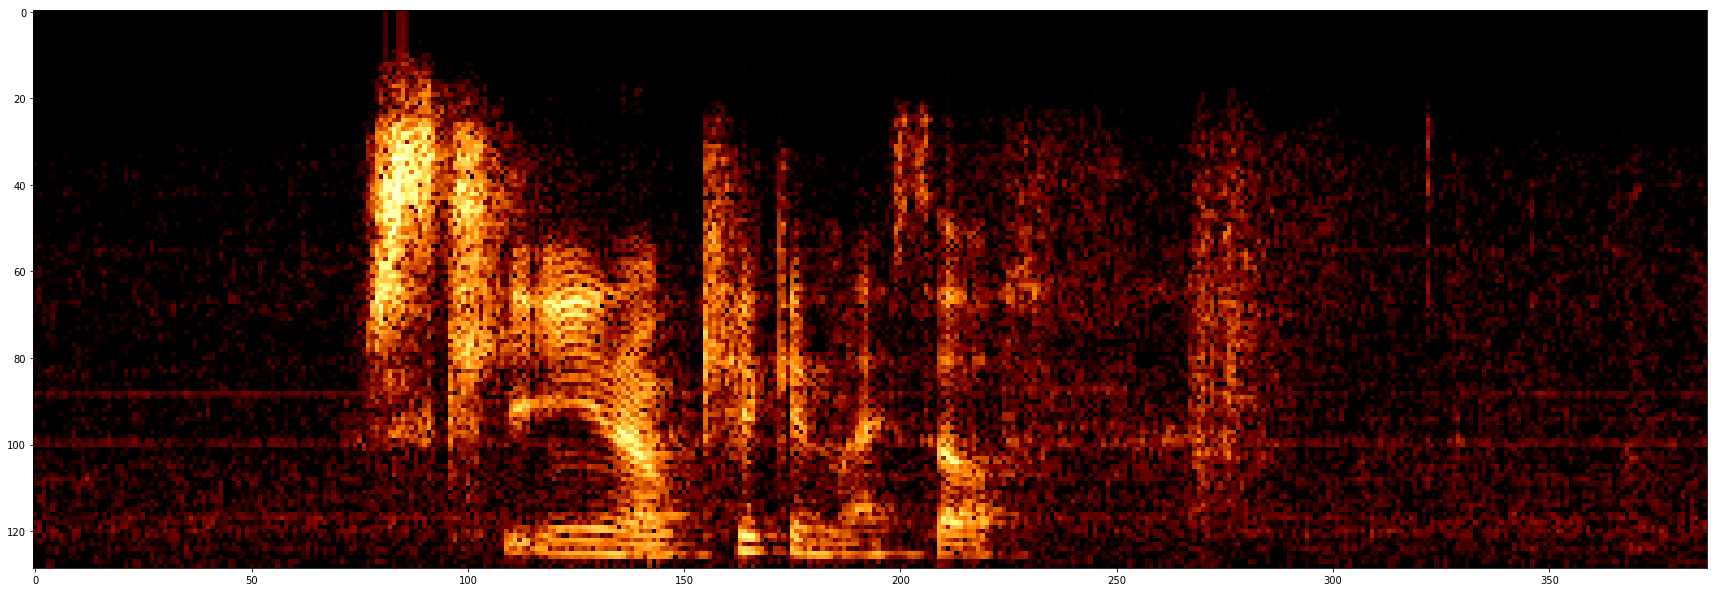

In [180]:
converter = SpectrogramConverter(frame_size=0.02, frame_stride=0.01, fft_size=256)
test_file = "Ses01F_impro02_F008.wav"

converter.load_wav(test_file)
converter.pre_emphasis()
converter.windowing()
spectrogram = converter.fourier_transform()

fig = plt.figure(figsize = (30, 20))
plt.imshow(numpy.rot90(spectrogram), interpolation='nearest', cmap='afmhot')
plt.imsave('fft_spectrogram.png', numpy.rot90(spectrogram), cmap='afmhot')

## Pipeline #2, with filter banks

C:\Users\marcelk\PycharmProjects\BCMarcel\venv\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in log10


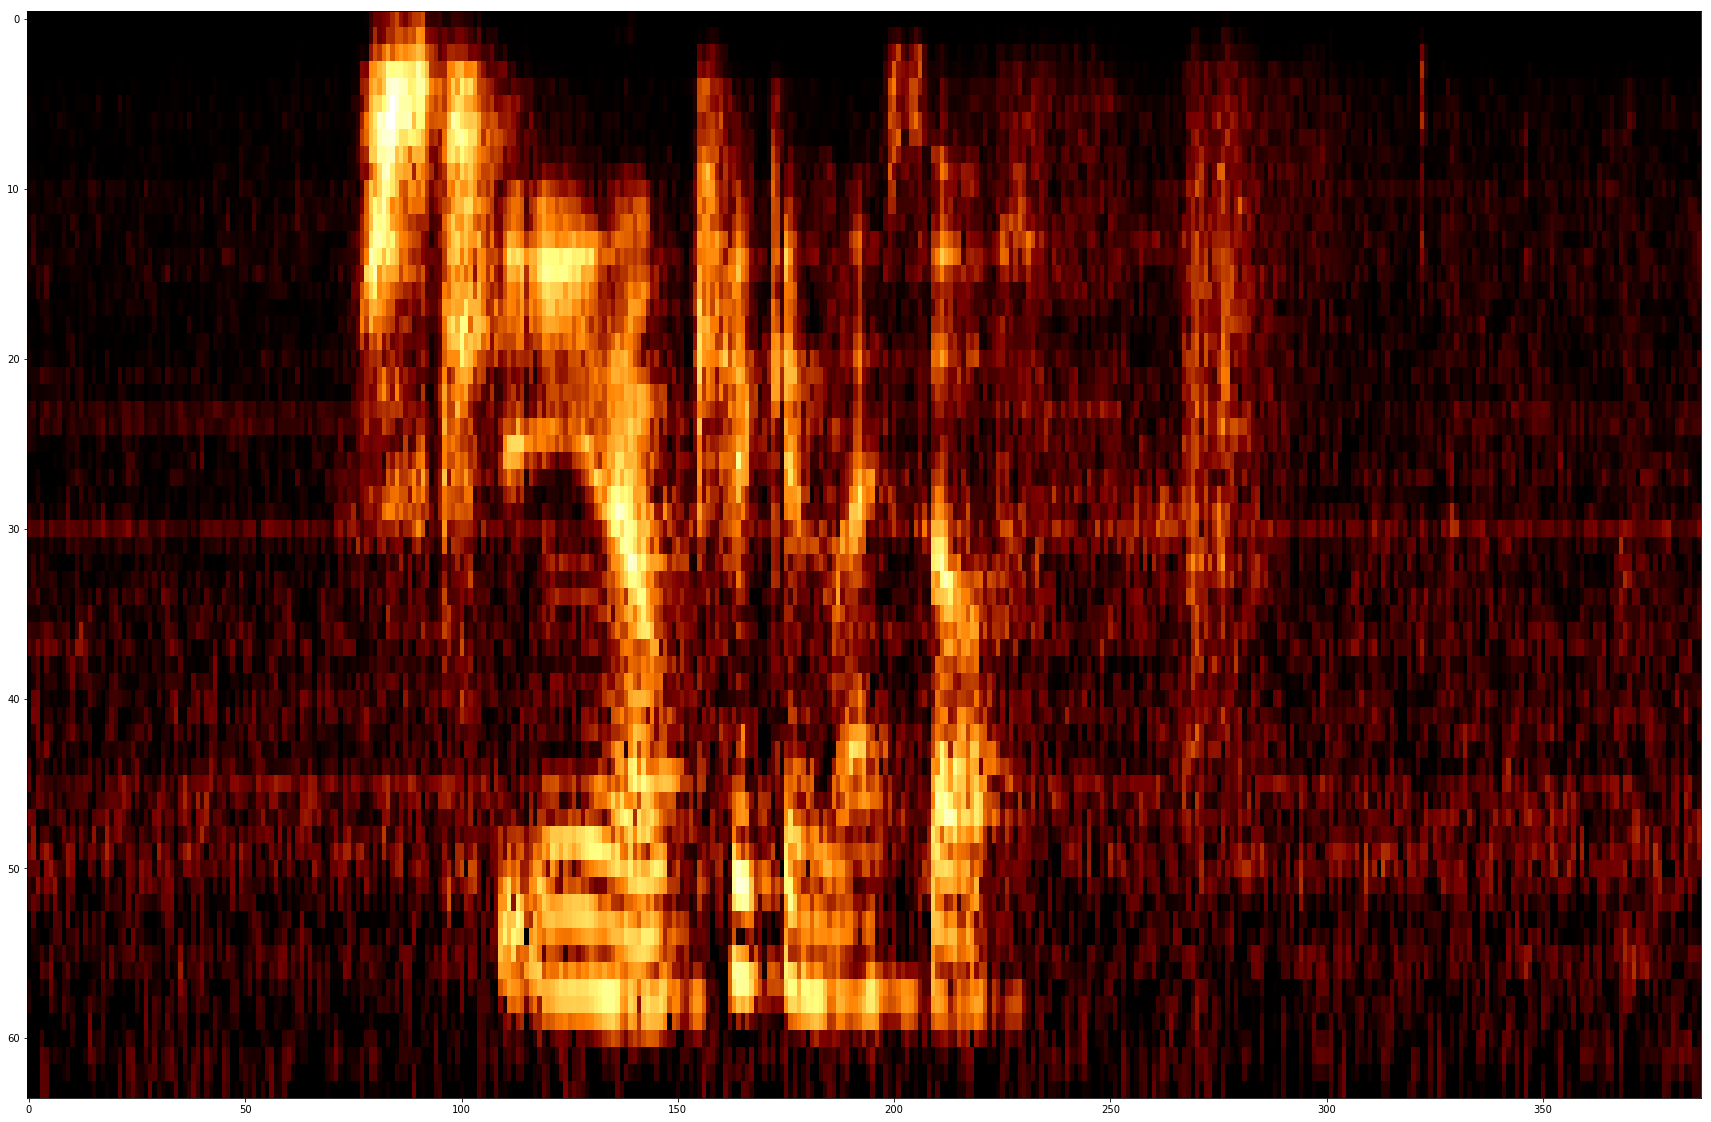

In [185]:
converter = SpectrogramConverter(frame_size=0.02, frame_stride=0.01, fft_size=512)
test_file = "Ses01F_impro02_F008.wav"

converter.load_wav(test_file)
converter.pre_emphasis()
converter.windowing()
spectrogram = converter.fourier_transform()
#converter.power_spectrum()
mel_spectrogram = converter.filter_banks(64)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (30, 20))
plt.imshow(numpy.flipud(mel_spectrogram), interpolation='nearest', cmap='afmhot', aspect='auto')
plt.imsave('mel_spectrogram.png', numpy.flipud(mel_spectrogram), cmap='afmhot')